# test for function to do data augmentation

## import packages

In [70]:
import os
import copy
import enum
from time import time
import random
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Compose
from torchvision.utils import make_grid, save_image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from unet import U_Net

from glob import glob
import pickle
warnings.filterwarnings('ignore')

import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM

from torch.utils.data import Dataset, SubsetRandomSampler

import numpy as np
import nibabel as nib
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

print('TorchIO version:', torchio.__version__)

training_split_ratio = 0.9
num_epochs = 5
compute_histograms = False
train_whole_images = False
train_patches = False

seed = 4460
torch.manual_seed(4460)
np.random.seed(4460)

TorchIO version: 0.15.5


In [71]:
from torchio.transforms import (
    RandomFlip, # check axis
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise, # lower noise
    RandomMotion, # no use
    RandomBiasField,
    RandomSpike,
    RandomBlur,
    Rescale,
    Resample,
    ToCanonical,
    ZNormalization,
    CenterCropOrPad,
    HistogramStandardization,
    Interpolation
)

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

Computation Details
	Device Used: (cuda)  Tesla K80

Packages Used Versions:-
	Pytorch Version: 1.4.0


# Define dataLoader for augmentation

In [73]:
# Dataset folder used
DATASET_PATH = os.path.join('./data')

# We would like to perform a train-validation-test split at the ratio of T:V:T = 8:1:1.
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Training Epochs
epochs = 100

In [74]:
class TumorDataset(Dataset):
    '''
    Returns a TumorDataset class object which represents our tumor dataset.
    TumorDataset inherits from torch.utils.data.Dataset class.
    '''

    def __init__(self, root_dir, DEBUG = False):
        '''
        Constructor for our TumorDataset class.
        Parameters:
            root_dir(str): Directory with all the images.
            DEBUG(bool): To switch to debug mode for image transformation.

        Returns: None
        '''
        self.root_dir = root_dir
        # The default transformation is composed of 
        # 1) a grayscale conversion.
        self.default_transformation = transforms.Compose([
            transforms.Grayscale()
        ])
        self.DEBUG = DEBUG

    def __getitem__(self, index):
        '''
        Overridden method from inheritted class to support
        indexing of dataset such that datset[I] can be used
        to get Ith sample.
        Parameters:
            index(int): Index of the dataset sample
            
        Return:
            sample(dict): Contains the index, image, mask torch.Tensor.
                        'index': Index of the image.
                        'image': Contains the tumor image torch.Tensor.
                        'mask' : Contains the mask image torch.Tensor.
        '''
        # Find the filenames for the tumor images and masks.
        image_path = os.path.join(self.root_dir, "all_gbm_pre_reg")
        tumor_path = os.path.join(self.root_dir, "all_tumors_reg")
        
        image_name = sorted(glob(os.path.join(image_path, "*t1reg.nii.gz")))[index]
        mask_name = sorted(glob(os.path.join(tumor_path, "*seg_reg.nii.gz")))[index]

        # Use nibabel to open the images and masks.
        image = nib.load(image_name).get_fdata()
        mask = nib.load(mask_name).get_fdata()

        # Apply the default transformations on the images and masks.
        #image = self.default_transformation(image)
        #mask = self.default_transformation(mask)

        # Convert the images and masks to tensor.
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Construct the images and masks together in the form of a dictionary.
        sample = {'index': index, 'image': image, 'mask': mask}
        return sample

    def __len__(self):
        '''Overridden method from inheritted class so that
        len(self) returns the size of the dataset.
        '''
        error_msg = 'Part of dataset is missing!\nNumber of tumor and mask images are not same.'
        total_image_files = len(glob(os.path.join(self.root_dir, 'all_gbm_pre_reg', '*t1reg.nii.gz')))
        total_tumor_files = len(glob(os.path.join(self.root_dir, 'all_tumors_reg', '*seg_reg.nii.gz')))

        # Sanity check: the number of files shall be even since tumor images and masks are in pairs.
        assert total_image_files == total_tumor_files, error_msg
        
        # Return how many image-mask pairs we have.
        return total_image_files
    


In [75]:
def get_indices(length, val_split, test_split):
    '''
    Gets the Training & Testing data indices for the dataset.
    Stores the indices and returns them back when the same dataset is used.
    Inputs:
        length(int): Length of the dataset used.
        val_split: the portion (0 to 1) of data used for validation.
        test_split: the portion (0 to 1) of data used for testing.
    Parameters:
        train_indices(list): Array of indices used for training purpose.
        validation_indices(list): Array of indices used for validation purpose.
        test_indices(list): Array of indices used for testing purpose.
    '''
    data = dict()
    indices = list(range(length))
    np.random.shuffle(indices)
    split1 = int(np.floor(test_split * len(tumor_dataset)))
    split2 = split1 + int(np.floor(val_split * len(tumor_dataset)))
    train_indices, validation_indices, test_indices = indices[split2:], indices[split1:split2], indices[:split1]
    return train_indices, validation_indices, test_indices

In [76]:
tumor_dataset = TumorDataset(DATASET_PATH)

train_indices, validation_indices, test_indices = get_indices(len(tumor_dataset), val_split = VAL_SPLIT, test_split = TEST_SPLIT)
train_sampler, validation_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler = train_sampler)
validationloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler = validation_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler = test_sampler)

print('Number of files in the train set: %s \nNumber of files in the validation set: %s \nNumber of files in the test set: %s' \
      % (len(train_indices), len(validation_indices), len(test_indices)))

Number of files in the train set: 269 
Number of files in the validation set: 33 
Number of files in the test set: 33


In [77]:
type(tumor_dataset.__getitem__(0)['image'])

torch.Tensor

In [78]:
dataPath = Path('./data')

t1_path = dataPath / 'all_gbm_pre_reg'
tumor_path = dataPath / 'all_tumors_reg'

t1_locations = sorted(t1_path.glob('*.nii.gz'))
tumor_locations = sorted(tumor_path.glob('*.nii.gz'))


assert len(t1_locations) == len(tumor_locations)

subjects = []
for (image_path, label_path) in zip(t1_locations, tumor_locations):
    subject = torchio.Subject(
        {'image': torchio.Image(image_path, torchio.INTENSITY),
        'mask': torchio.Image(label_path, torchio.LABEL)}
    )
    subjects.append(subject)
    
dataset = torchio.ImagesDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 335 subjects


In [79]:
type(dataset[0]['image']['data'])

torch.Tensor

In [80]:
len(train_indices)

269

In [81]:
trainsubjects = []

for i in train_indices:
    trainsubjects.append(subjects[i])
    
trainset = torchio.ImagesDataset(trainsubjects)

In [13]:
type(trainset[0]['mask']['data'])

torch.Tensor

In [14]:
len(trainset)

269

In [15]:
# bf_train_set = []

# for i in range(len(trainset)): 
#     bf_train_set.append({'image': trainset[i]['image']['data'], 'mask': trainset[i]['mask']['data']})
#     bf = RandomBiasField(coefficients=(0,0.7),proportion_to_augment=1, seed=seed)
#     bf_trans = bf(trainset[i])
#     bf_train_set.append({'image': bf_trans['image']['data'], 'mask': bf_trans['mask']['data']})

# working on dataloader

In [36]:
class DataAugNoise(Dataset):
    '''
    Returns a TumorDataset class object which represents our tumor dataset.
    TumorDataset inherits from torch.utils.data.Dataset class.
    '''

    def __init__(self, root_dir, DEBUG = False):
        '''
        Constructor for our TumorDataset class.
        Parameters:
            root_dir(str): Directory with all the images.
            DEBUG(bool): To switch to debug mode for image transformation.

        Returns: None
        '''
        self.root_dir = root_dir
        # The default transformation is composed of 
        # 1) a grayscale conversion.
        self.default_transformation = transforms.Compose([
            torchio.transforms.RandomNoise(std=(0,150),seed=seed)
        ])
        self.DEBUG = DEBUG

    def __getitem__(self, index):
        '''
        Overridden method from inheritted class to support
        indexing of dataset such that datset[I] can be used
        to get Ith sample.
        Parameters:
            index(int): Index of the dataset sample
            
        Return:
            sample(dict): Contains the index, image, mask torch.Tensor.
                        'index': Index of the image.
                        'image': Contains the tumor image torch.Tensor.
                        'mask' : Contains the mask image torch.Tensor.
        '''
        # Find the filenames for the tumor images and masks.
        image_path = os.path.join(self.root_dir, "all_gbm_pre_reg")
        tumor_path = os.path.join(self.root_dir, "all_tumors_reg")
        
        image_name = sorted(glob(os.path.join(image_path, "*t1reg.nii.gz")))[index]
        mask_name = sorted(glob(os.path.join(tumor_path, "*seg_reg.nii.gz")))[index]

        # Use nibabel to open the images and masks.
        image = nib.load(image_name).get_fdata()
        mask = nib.load(mask_name).get_fdata()

        # Apply the default transformations on the images and masks.
#         image = self.default_transformation(image)
#         mask = self.default_transformation(mask)

        # Convert the images and masks to tensor.
        image = TF.to_tensor(image)
#         image = self.default_transformation(image)
        mask = TF.to_tensor(mask)
#         mask = self.default_transformation(mask)

        # Construct the images and masks together in the form of a dictionary.
        sample = {'index': index, 'image': image, 'mask': mask}
        return sample

    def __len__(self):
        '''Overridden method from inheritted class so that
        len(self) returns the size of the dataset.
        '''
        error_msg = 'Part of dataset is missing!\nNumber of tumor and mask images are not same.'
        total_image_files = len(glob(os.path.join(self.root_dir, 'all_gbm_pre_reg', '*t1reg.nii.gz')))
        total_tumor_files = len(glob(os.path.join(self.root_dir, 'all_tumors_reg', '*seg_reg.nii.gz')))

        # Sanity check: the number of files shall be even since tumor images and masks are in pairs.
        assert total_image_files == total_tumor_files, error_msg
        
        # Return how many image-mask pairs we have.
        return total_image_files
    


In [37]:
# img = nib.load('./data/all_gbm_pre_reg/BraTS19_2013_1_1_t1reg.nii.gz').get_fdata()
# type(img)

In [38]:
noise_tumor_dataset = DataAugNoise(DATASET_PATH)

In [39]:
# type(Noise_tumor_dataset)

In [41]:
noise_tumor_dataset.__getitem__(0)['image'].size()

torch.Size([155, 240, 240])

In [43]:
len(tumor_dataset)

335

In [82]:
# # not working
# # RuntimeError: Could not run 'aten::values' with arguments from the 'CPUTensorId' backend. 'aten::values' is only available for these backends: [SparseCPUTensorId, VariableTensorId, SparseCUDATensorId].
# assert len(tumor_dataset) == len(noise_tumor_dataset)


# for i in range(len(tumor_dataset)): 
#     noise_transform = torchio.transforms.RandomNoise(std=(0,150),seed=seed)
#     noise_tumor_dataset.__getitem__(i)['image'] = noise_transform(tumor_dataset.__getitem__(i)['image'])
#     noise_tumor_dataset.__getitem__(i)['mask'] = noise_transform(tumor_dataset.__getitem__(i)['mask'])
    

# working on the 'dataset'

In [83]:
dataPath = Path('./data')

t1_path = dataPath / 'all_gbm_pre_reg'
tumor_path = dataPath / 'all_tumors_reg'

t1_locations = sorted(t1_path.glob('*.nii.gz'))
tumor_locations = sorted(tumor_path.glob('*.nii.gz'))


assert len(t1_locations) == len(tumor_locations)

subjects = []
for (image_path, label_path) in zip(t1_locations, tumor_locations):
    subject = torchio.Subject(
        {'image': torchio.Image(image_path, torchio.INTENSITY),
        'mask': torchio.Image(label_path, torchio.LABEL)}
    )
    subjects.append(subject)
    
dataset = torchio.ImagesDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 335 subjects


In [84]:
# Some visualization functions

def show_nifti(image_path_or_image, colormap='gray'):
    try:
        from niwidgets import NiftiWidget
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            widget = NiftiWidget(image_path_or_image)
            widget.nifti_plotter(colormap=colormap)
    except Exception:
        if isinstance(image_path_or_image, nib.AnalyzeImage):
            nii = image_path_or_image
        else:
            image_path = image_path_or_image
            nii = nib.load(str(image_path))
        k = int(nii.shape[-1] / 2)
        plt.imshow(nii.dataobj[..., k], cmap=colormap)

def show_sample(sample, image_name, label_name=None):
    if label_name is not None:
        sample = copy.deepcopy(sample)
        affine = sample[label_name][AFFINE]
        label = sample[label_name][DATA][0].numpy().astype(np.uint8)
        label_image = torchio.utils.nib_to_sitk(label, affine)
        border = sitk.BinaryContour(label_image)
        border_array, _ = torchio.utils.sitk_to_nib(border)
        border_tensor = torch.from_numpy(border_array)
        image_tensor = sample[image_name][DATA][0]
        image_tensor[border_tensor > 0.5] = image_tensor.max()
    with tempfile.NamedTemporaryFile(suffix='.nii') as f:
        torchio.ImagesDataset.save_sample(sample, {image_name: f.name})
        show_nifti(f.name)

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

In [86]:
# type(dataset)
# sample = dataset[0]
# type(sample)
# sample

In [87]:
# some example exploration to figure out data structure

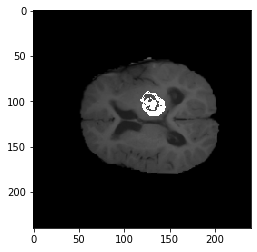

In [88]:
sample = dataset[0]
show_sample(sample, 'image', label_name='mask')

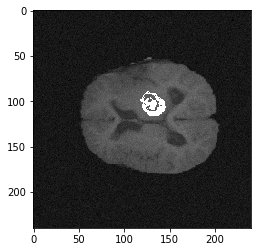

In [89]:
noise_transform = torchio.transforms.RandomNoise(std=(0,150),seed=seed)
transformed = noise_transform(sample)
show_sample(transformed, 'image', label_name='mask')

In [91]:
# transformed

In [92]:
## not working 
## RuntimeError: Could not run 'aten::values' with arguments from the 'CPUTensorId' backend. 'aten::values' is only available for these backends: [SparseCPUTensorId, VariableTensorId, SparseCUDATensorId].
# noise_dataset = [dataset]

# for i in range(10): 
#     noise_transform = torchio.transforms.RandomNoise(std=(0,150),seed=seed)
#     noise_dataset[i]['image']['data'] = noise_transform(dataset[i]['image']['data'])
#     noise_dataset[i]['mask']['data'] = noise_transform(dataset[i]['mask']['data'])
#     show_sample(noise_dataset[i], 'image', label_name='mask')

In [93]:
noise_dataset = []

for i in range(len(dataset)): 
    noise_transform = torchio.transforms.RandomNoise(std=(0,150),seed=seed)
    transformed = noise_transform(dataset[i])
    noise_dataset.append(transformed)
#     show_sample(transformed, 'image', label_name='mask')

In [69]:
len(noise_dataset)

335

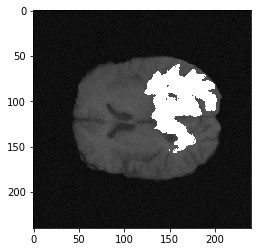

In [97]:
for i in range(10): 
    show_sample(noise_dataset[i], 'image', label_name = "mask")